In [1]:
import os
os.listdir("/content")


['.config', 'kaggle.json', '.ipynb_checkpoints', 'sample_data']

In [2]:
!ls /content


kaggle.json  sample_data


In [3]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d mostafaabla/garbage-classification -p /content


Dataset URL: https://www.kaggle.com/datasets/mostafaabla/garbage-classification
License(s): ODbL-1.0
 64% 152M/239M [00:00<00:00, 1.59GB/s]
100% 239M/239M [00:00<00:00, 837MB/s] 


In [5]:
!unzip -q /content/garbage-classification.zip -d /content/garbage_dataset


In [6]:
import os
os.listdir("/content/garbage_dataset")


['garbage_classification']

In [7]:
import os
os.listdir("/content/garbage_dataset")


['garbage_classification']

In [8]:
import os
os.listdir("/content/garbage_dataset/garbage_classification")


['brown-glass',
 'green-glass',
 'battery',
 'plastic',
 'shoes',
 'cardboard',
 'white-glass',
 'metal',
 'clothes',
 'paper',
 'biological',
 'trash']

In [9]:
import os
import shutil
from sklearn.model_selection import train_test_split

base_path = "/content/garbage_dataset/garbage_classification"
train_path = "/content/garbage_split/train"
val_path = "/content/garbage_split/val"

os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)

classes = os.listdir(base_path)

for cls in classes:
    cls_folder = os.path.join(base_path, cls)
    images = [f for f in os.listdir(cls_folder) if f.lower().endswith(('jpg','jpeg','png'))]

    train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)

    # Create class folders
    os.makedirs(os.path.join(train_path, cls), exist_ok=True)
    os.makedirs(os.path.join(val_path, cls), exist_ok=True)

    # Copy files
    for img in train_imgs:
        shutil.copy(os.path.join(cls_folder, img), os.path.join(train_path, cls))

    for img in val_imgs:
        shutil.copy(os.path.join(cls_folder, img), os.path.join(val_path, cls))

print("Split complete!")


Split complete!


In [10]:
for cls in classes:
    print(cls,
          "Train =", len(os.listdir(os.path.join(train_path, cls))),
          "Val =", len(os.listdir(os.path.join(val_path, cls))))


brown-glass Train = 485 Val = 122
green-glass Train = 503 Val = 126
battery Train = 756 Val = 189
plastic Train = 692 Val = 173
shoes Train = 1581 Val = 396
cardboard Train = 712 Val = 179
white-glass Train = 620 Val = 155
metal Train = 615 Val = 154
clothes Train = 4260 Val = 1065
paper Train = 840 Val = 210
biological Train = 788 Val = 197
trash Train = 557 Val = 140


In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os


In [13]:
train_path = "/content/garbage_split/train"
val_path = "/content/garbage_split/val"

datagen_train = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
)

datagen_val = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_data = datagen_train.flow_from_directory(
    train_path,
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical"
)

val_data = datagen_val.flow_from_directory(
    val_path,
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical"
)

class_names = list(train_data.class_indices.keys())
print(class_names)


Found 12409 images belonging to 12 classes.
Found 3106 images belonging to 12 classes.
['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


In [14]:
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

# Freeze base layers first
for layer in base_model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,115,340 (91.99 MB)

 Trainable params: 527,628 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [15]:
history1 = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 193s 458ms/step - accuracy: 0.6567 - loss: 1.1478 - val_accuracy: 0.9282 - val_loss: 0.2592
Epoch 2/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 164s 423ms/step - accuracy: 0.9007 - loss: 0.3274 - val_accuracy: 0.9404 - val_loss: 0.1992
Epoch 3/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 162s 418ms/step - accuracy: 0.9311 - loss: 0.2246 - val_accuracy: 0.9453 - val_loss: 0.1740
Epoch 4/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 162s 417ms/step - accuracy: 0.9463 - loss: 0.1764 - val_accuracy: 0.9501 - val_loss: 0.1596
Epoch 5/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 163s 420ms/step - accuracy: 0.9515 - loss: 0.1538 - val_accuracy: 0.9517 - val_loss: 0.1526
Epoch 6/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 162s 418ms/step - accuracy: 0.9568 - loss: 0.1312 - val_accuracy: 0.9536 - val_loss: 0.1468
Epoch 7/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 162s 419ms/step - accuracy: 0.9618 - loss: 0.1155 - val_accuracy: 0.9530 - val_loss: 0.1520
Epoch 8/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 161s 415ms/step - accuracy: 0.9665 -

In [16]:
for layer in base_model.layers[-50:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history2 = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    verbose=1,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ModelCheckpoint("garbage_resnet50_best.h5", monitor="val_accuracy", save_best_only=True)
    ]
)


Epoch 1/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.9540 - loss: 0.1423

388/388 ━━━━━━━━━━━━━━━━━━━━ 212s 483ms/step - accuracy: 0.9540 - loss: 0.1422 - val_accuracy: 0.9598 - val_loss: 0.1268
Epoch 2/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.9701 - loss: 0.0898

388/388 ━━━━━━━━━━━━━━━━━━━━ 172s 442ms/step - accuracy: 0.9701 - loss: 0.0898 - val_accuracy: 0.9636 - val_loss: 0.1175
Epoch 3/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.9767 - loss: 0.0710

388/388 ━━━━━━━━━━━━━━━━━━━━ 166s 428ms/step - accuracy: 0.9767 - loss: 0.0710 - val_accuracy: 0.9672 - val_loss: 0.1091
Epoch 4/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 164s 424ms/step - accuracy: 0.9846 - loss: 0.0513 - val_accuracy: 0.9656 - val_loss: 0.1056
Epoch 5/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.9870 - loss: 0.0417

388/388 ━━━━━━━━━━━━━━━━━━━━ 167s 430ms/step - accuracy: 0.9870 - loss: 0.0417 - val_accuracy: 0.9684 - val_loss: 0.1068
Epoch 6/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.9867 - loss: 0.0424

388/388 ━━━━━━━━━━━━━━━━━━━━ 167s 430ms/step - accuracy: 0.9867 - loss: 0.0424 - val_accuracy: 0.9720 - val_loss: 0.1047
Epoch 7/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 166s 428ms/step - accuracy: 0.9910 - loss: 0.0292 - val_accuracy: 0.9691 - val_loss: 0.1064
Epoch 8/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 165s 426ms/step - accuracy: 0.9932 - loss: 0.0246 - val_accuracy: 0.9704 - val_loss: 0.1071
Epoch 9/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.9942 - loss: 0.0202

388/388 ━━━━━━━━━━━━━━━━━━━━ 167s 431ms/step - accuracy: 0.9942 - loss: 0.0202 - val_accuracy: 0.9733 - val_loss: 0.1078


In [18]:
from tensorflow.keras.models import load_model
model = load_model("garbage_resnet50_best.h5")
print("Model loaded!")


Model loaded!


In [19]:
for layer in model.layers[-50:]:
    layer.trainable = True


In [20]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

correct_val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

correct_val = correct_val_gen.flow_from_directory(
    val_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False     # ❗ VERY IMPORTANT
)

class_names = list(correct_val.class_indices.keys())
print(class_names)


Found 3106 images belonging to 12 classes.
['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


In [25]:
from tensorflow.keras.models import load_model
model = load_model("garbage_resnet50_finetuned.h5")


In [26]:
preds = model.predict(correct_val)
y_pred = preds.argmax(axis=1)
y_true = correct_val.classes


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


98/98 ━━━━━━━━━━━━━━━━━━━━ 16s 121ms/step


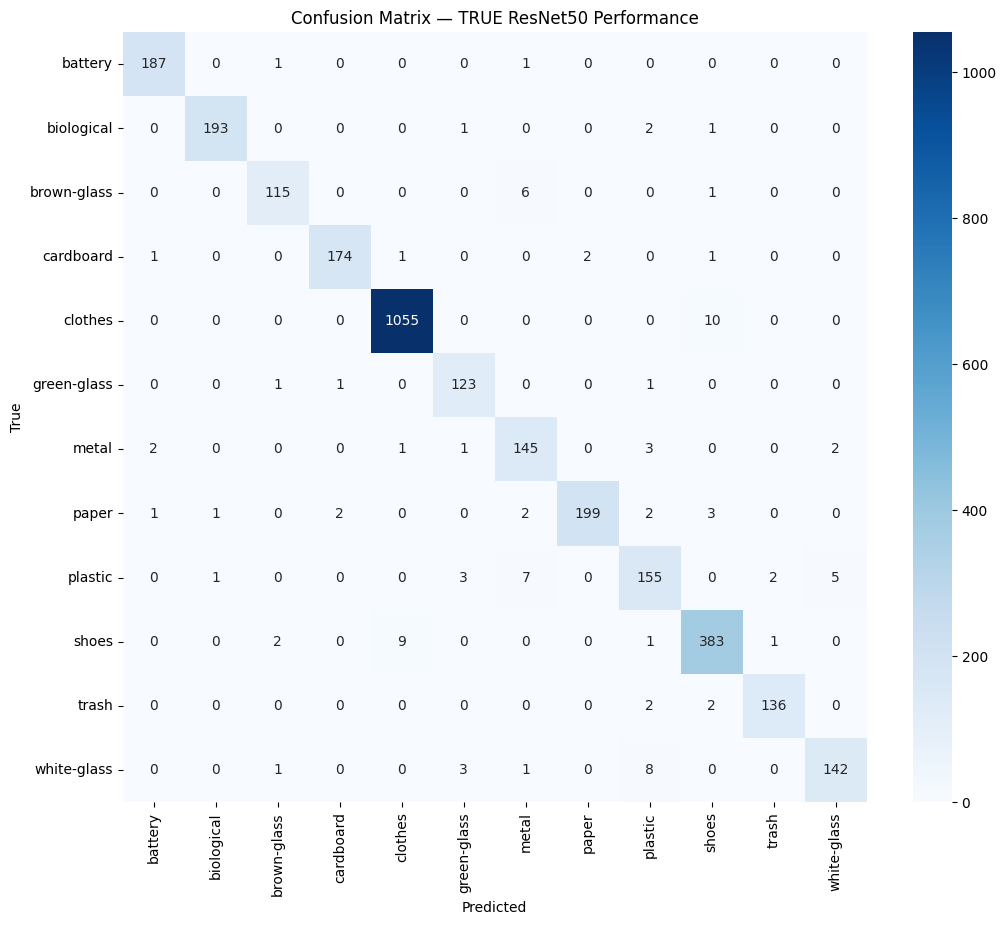


Classification Report:

              precision    recall  f1-score   support

     battery       0.98      0.99      0.98       189
  biological       0.99      0.98      0.98       197
 brown-glass       0.96      0.94      0.95       122
   cardboard       0.98      0.97      0.98       179
     clothes       0.99      0.99      0.99      1065
 green-glass       0.94      0.98      0.96       126
       metal       0.90      0.94      0.92       154
       paper       0.99      0.95      0.97       210
     plastic       0.89      0.90      0.89       173
       shoes       0.96      0.97      0.96       396
       trash       0.98      0.97      0.97       140
 white-glass       0.95      0.92      0.93       155

    accuracy                           0.97      3106
   macro avg       0.96      0.96      0.96      3106
weighted avg       0.97      0.97      0.97      3106



In [27]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix — TRUE ResNet50 Performance")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


In [28]:
model.save("resnet50_final.h5")
print("Model saved as resnet50_final.h5")


Model saved as resnet50_final.h5


In [30]:
from google.colab import files
files.download("resnet50_final.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>